## Experience Analytics

In [1]:
# Importing useful libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans

In [2]:
# Libraries used to connect to database
from sqlalchemy import create_engine
from sqlalchemy.exc import SQLAlchemyError
import psycopg2

In [3]:
# Adjust the path as needed based on the notebook's location relative to the src directory
import sys
sys.path.append("../src")  

In [4]:
# Helper functions

# Data loading function from the src.loader module
from loader import connect_to_database, import_data_to_dataframe, create_table, save_to_db

# Util functions
from utils import get_mean, get_numeric_columns, detect_outliers_zscore, analyze_cluster_dispersion, get_cluster_dispersion_columns

# Ploting function
from plots import cluster_plot_2d, plot_cluster_dispersion_subplots

In [5]:
# Constant DB connection parameters VARIABLES
USERNAME = 'postgres'
PWD = 'mikias'
HOST = 'localhost' 
PORT = '5432'  
DB = 'telecom'
TABLE = 'xdr_data'

In [6]:
# Connect to the database
engine = connect_to_database(USERNAME, PWD, HOST, PORT, DB)

if engine is not None:
    # Import data from the table into a DataFrame
    df = import_data_to_dataframe(engine, TABLE)

    if df is not None:
        # Display the DataFrame
        print(df.head())
    else:
        print("Error: Failed to import data into DataFrame.")

Successfully connected to the database!
      Bearer Id            Start  Start ms              End  End ms  \
0  1.311448e+19   4/4/2019 12:01     770.0  4/25/2019 14:35   662.0   
1  1.311448e+19   4/9/2019 13:04     235.0   4/25/2019 8:15   606.0   
2  1.311448e+19   4/9/2019 17:42       1.0  4/25/2019 11:58   652.0   
3  1.311448e+19   4/10/2019 0:31     486.0   4/25/2019 7:36   171.0   
4  1.311448e+19  4/12/2019 20:10     565.0  4/25/2019 10:40   954.0   

   Dur. (ms)          IMSI  MSISDN/Number          IMEI  \
0  1823652.0  2.082014e+14   3.366496e+10  3.552121e+13   
1  1365104.0  2.082019e+14   3.368185e+10  3.579401e+13   
2  1361762.0  2.082003e+14   3.376063e+10  3.528151e+13   
3  1321509.0  2.082014e+14   3.375034e+10  3.535661e+13   
4  1089009.0  2.082014e+14   3.369980e+10  3.540701e+13   

      Last Location Name        ...         Youtube DL (Bytes)  \
0  9.16456699548519E+015        ...                 15854611.0   
1                L77566A        ...           

In [7]:
mean_row = get_mean(df)

# Output the mean values
print("Mean values of numerical columns:")
print(mean_row[:10])

Mean values of numerical columns:
Bearer Id                  1.013887e+19
Start ms                   4.991882e+02
End ms                     4.988009e+02
Dur. (ms)                  1.046086e+05
IMSI                       2.082016e+14
MSISDN/Number              4.188282e+10
IMEI                       4.847455e+13
Avg RTT DL (ms)            1.097957e+02
Avg RTT UL (ms)            1.766288e+01
Avg Bearer TP DL (kbps)    1.330005e+04
Name: mean, dtype: float64


In [8]:
# Fill null values with mean values
df_filled = df.fillna(mean_row)

# Output the DataFrame after filling null values
print("DataFrame after filling null values with mean:")
print(df_filled.head())

DataFrame after filling null values with mean:
      Bearer Id            Start  Start ms              End  End ms  \
0  1.311448e+19   4/4/2019 12:01     770.0  4/25/2019 14:35   662.0   
1  1.311448e+19   4/9/2019 13:04     235.0   4/25/2019 8:15   606.0   
2  1.311448e+19   4/9/2019 17:42       1.0  4/25/2019 11:58   652.0   
3  1.311448e+19   4/10/2019 0:31     486.0   4/25/2019 7:36   171.0   
4  1.311448e+19  4/12/2019 20:10     565.0  4/25/2019 10:40   954.0   

   Dur. (ms)          IMSI  MSISDN/Number          IMEI  \
0  1823652.0  2.082014e+14   3.366496e+10  3.552121e+13   
1  1365104.0  2.082019e+14   3.368185e+10  3.579401e+13   
2  1361762.0  2.082003e+14   3.376063e+10  3.528151e+13   
3  1321509.0  2.082014e+14   3.375034e+10  3.535661e+13   
4  1089009.0  2.082014e+14   3.369980e+10  3.540701e+13   

      Last Location Name        ...         Youtube DL (Bytes)  \
0  9.16456699548519E+015        ...                 15854611.0   
1                L77566A        ...    

In [9]:
# Helper function return numerical columns from the dataframe
numeric_columns = get_numeric_columns(df)

In [10]:
# Making a copy of filled dataframe
df_no_outlier = df_filled.copy()

# Loop over the numerical columns except for bearer_id to change the outliers with the mean values
for i in range(1, len(numeric_columns)):
    # Check for outlier for the numeric columns 
    column_name = numeric_columns[i]
    outliers = detect_outliers_zscore(df_no_outlier[column_name])

    # Replace outliers with the mean value
    mean_value = mean_row[column_name]
    df_no_outlier.loc[outliers, column_name] = mean_value

In [11]:
# Print the DataFrame after replacing outliers with the mean value
print("DataFrame after replacing outliers with the mean value:")
df_no_outlier.head(3)

DataFrame after replacing outliers with the mean value:


,Bearer Id,Start,Start ms,End,End ms,Dur. (ms),IMSI,MSISDN/Number,IMEI,Last Location Name,...,Youtube DL (Bytes),Youtube UL (Bytes),Netflix DL (Bytes),Netflix UL (Bytes),Gaming DL (Bytes),Gaming UL (Bytes),Other DL (Bytes),Other UL (Bytes),Total UL (Bytes),Total DL (Bytes)
0,1.311448e+19,4/4/2019 12:01,770.0,4/25/2019 14:35,662.0,104608.560347,2.082014e+14,3.366496e+10,3.552121e+13,9.16456699548519E+015,...,15854611.0,2501332.0,8198936.0,9656251.0,278082303.0,14344150.0,171744450.0,8814393.0,36749741.0,308879636.0
1,1.311448e+19,4/9/2019 13:04,235.0,4/25/2019 8:15,606.0,104608.560347,2.082019e+14,3.368185e+10,3.579401e+13,L77566A,...,20247395.0,19111729.0,18338413.0,17227132.0,608750074.0,1170709.0,526904238.0,15055145.0,53800391.0,653384965.0
2,1.311448e+19,4/9/2019 17:42,1.0,4/25/2019 11:58,652.0,104608.560347,2.082003e+14,3.376063e+10,3.528151e+13,D42335A,...,19725661.0,14699576.0,17587794.0,6163408.0,229584621.0,395630.0,410692588.0,4215763.0,27883638.0,279807335.0


In [12]:
df_no_outlier.columns

Index(['Bearer Id', 'Start', 'Start ms', 'End', 'End ms', 'Dur. (ms)', 'IMSI',
       'MSISDN/Number', 'IMEI', 'Last Location Name', 'Avg RTT DL (ms)',
       'Avg RTT UL (ms)', 'Avg Bearer TP DL (kbps)', 'Avg Bearer TP UL (kbps)',
       'TCP DL Retrans. Vol (Bytes)', 'TCP UL Retrans. Vol (Bytes)',
       'DL TP < 50 Kbps (%)', '50 Kbps < DL TP < 250 Kbps (%)',
       '250 Kbps < DL TP < 1 Mbps (%)', 'DL TP > 1 Mbps (%)',
       'UL TP < 10 Kbps (%)', '10 Kbps < UL TP < 50 Kbps (%)',
       '50 Kbps < UL TP < 300 Kbps (%)', 'UL TP > 300 Kbps (%)',
       'HTTP DL (Bytes)', 'HTTP UL (Bytes)', 'Activity Duration DL (ms)',
       'Activity Duration UL (ms)', 'Dur. (ms).1', 'Handset Manufacturer',
       'Handset Type', 'Nb of sec with 125000B < Vol DL',
       'Nb of sec with 1250B < Vol UL < 6250B',
       'Nb of sec with 31250B < Vol DL < 125000B',
       'Nb of sec with 37500B < Vol UL',
       'Nb of sec with 6250B < Vol DL < 31250B',
       'Nb of sec with 6250B < Vol UL < 37500B',


In [13]:
df_no_outlier.isna().sum()

Bearer Id                                      0
Start                                          1
Start ms                                       0
End                                            1
End ms                                         0
Dur. (ms)                                      0
IMSI                                           0
MSISDN/Number                                  0
IMEI                                           0
Last Location Name                          1153
Avg RTT DL (ms)                                0
Avg RTT UL (ms)                                0
Avg Bearer TP DL (kbps)                        0
Avg Bearer TP UL (kbps)                        0
TCP DL Retrans. Vol (Bytes)                    0
TCP UL Retrans. Vol (Bytes)                    0
DL TP < 50 Kbps (%)                            0
50 Kbps < DL TP < 250 Kbps (%)                 0
250 Kbps < DL TP < 1 Mbps (%)                  0
DL TP > 1 Mbps (%)                             0
UL TP < 10 Kbps (%) 

In [14]:
# Select relevant columns for aggregation
relevant_columns = ['MSISDN/Number', 'TCP DL Retrans. Vol (Bytes)', 'TCP UL Retrans. Vol (Bytes)',
                    'Avg RTT DL (ms)', 'Avg RTT UL (ms)', 'Handset Type',
                    'Avg Bearer TP DL (kbps)', 'Avg Bearer TP UL (kbps)']

# Aggregate information per customer
customer_info = df_no_outlier.groupby('MSISDN/Number').agg({
    'TCP DL Retrans. Vol (Bytes)': 'mean',
    'TCP UL Retrans. Vol (Bytes)': 'mean',
    'Avg RTT DL (ms)': 'mean',
    'Avg RTT UL (ms)': 'mean',
    'Handset Type': lambda x: x.mode().iat[0],  # Mode of handset type
    'Avg Bearer TP DL (kbps)': 'mean',
    'Avg Bearer TP UL (kbps)': 'mean'
}).reset_index()


In [15]:
# Rename columns for clarity
customer_info.rename(columns={'TCP DL Retrans. Vol (Bytes)': 'Average TCP Retransmission (DL)',
                              'TCP UL Retrans. Vol (Bytes)': 'Average TCP Retransmission (UL)',
                              'Avg RTT DL (ms)': 'Average RTT (DL)',
                              'Avg RTT UL (ms)': 'Average RTT (UL)',
                              'Handset Type': 'Most Common Handset Type',
                              'Avg Bearer TP DL (kbps)': 'Average Throughput (DL)',
                              'Avg Bearer TP UL (kbps)': 'Average Throughput (UL)'}, inplace=True)

# Display aggregated information per customer
customer_info.head()

,MSISDN/Number,Average TCP Retransmission (DL),Average TCP Retransmission (UL),Average RTT (DL),Average RTT (UL),Most Common Handset Type,Average Throughput (DL),Average Throughput (UL)
0,3.360100e+10,2.080991e+07,759658.664811,46.000000,0.000000,Huawei P20 Lite Huawei Nova 3E,37.0,39.000000
1,3.360100e+10,2.080991e+07,759658.664811,30.000000,1.000000,Apple iPhone 7 (A1778),48.0,51.000000
2,3.360100e+10,2.080991e+07,759658.664811,109.795706,17.662883,undefined,48.0,49.000000
3,3.360101e+10,1.066000e+03,759658.664811,69.000000,15.000000,Apple iPhone 5S (A1457),204.0,44.000000
4,3.360101e+10,1.507977e+07,390430.332406,57.000000,2.500000,Apple iPhone Se (A1723),20197.5,905.214323


In [16]:
customer_info['Average TCP Retransmission Total'] = customer_info['Average TCP Retransmission (DL)'] + customer_info['Average TCP Retransmission (UL)']
customer_info['Average RTT Total'] = customer_info['Average RTT (DL)'] + customer_info['Average RTT (UL)']
customer_info['Average Throughput Total'] = customer_info['Average Throughput (DL)'] + customer_info['Average Throughput (UL)']
customer_info.head()

,MSISDN/Number,Average TCP Retransmission (DL),Average TCP Retransmission (UL),Average RTT (DL),Average RTT (UL),Most Common Handset Type,Average Throughput (DL),Average Throughput (UL),Average TCP Retransmission Total,Average RTT Total,Average Throughput Total
0,3.360100e+10,2.080991e+07,759658.664811,46.000000,0.000000,Huawei P20 Lite Huawei Nova 3E,37.0,39.000000,2.156957e+07,46.000000,76.000000
1,3.360100e+10,2.080991e+07,759658.664811,30.000000,1.000000,Apple iPhone 7 (A1778),48.0,51.000000,2.156957e+07,31.000000,99.000000
2,3.360100e+10,2.080991e+07,759658.664811,109.795706,17.662883,undefined,48.0,49.000000,2.156957e+07,127.458589,97.000000
3,3.360101e+10,1.066000e+03,759658.664811,69.000000,15.000000,Apple iPhone 5S (A1457),204.0,44.000000,7.607247e+05,84.000000,248.000000
4,3.360101e+10,1.507977e+07,390430.332406,57.000000,2.500000,Apple iPhone Se (A1723),20197.5,905.214323,1.547020e+07,59.500000,21102.714323


In [17]:
# Sorting customer's network information by respective network performance metrics
sorted_tcp_ret = customer_info.sort_values(ascending=False, by='Average TCP Retransmission Total')\
    [['MSISDN/Number', 'Average TCP Retransmission Total', 'Most Common Handset Type']]
sorted_rtt_total = customer_info.sort_values(ascending=False, by='Average RTT Total')\
    [['MSISDN/Number', 'Average RTT Total', 'Most Common Handset Type']]
sorted_tp_total = customer_info.sort_values(ascending=False, by='Average Throughput Total')\
    [['MSISDN/Number', 'Average Throughput Total', 'Most Common Handset Type']]

In [18]:
# Top 10 users with high TCP Retransmission 
print('Top 10 TCP Retransmission per user along with their handset types.')
sorted_tcp_ret.head(10)

Top 10 TCP Retransmission per user along with their handset types.


,MSISDN/Number,Average TCP Retransmission Total,Most Common Handset Type
47144,3.366212e+10,3.687675e+08,Huawei E5573
58387,3.366501e+10,3.684462e+08,Huawei B528S-23A
59734,3.366537e+10,3.661276e+08,Huawei B528S-23A
96372,3.376180e+10,3.638227e+08,Huawei B528S-23A
22440,3.364886e+10,3.622126e+08,Samsung Galaxy S6 (Sm-G920X)
23388,3.365011e+10,3.592816e+08,Huawei B528S-23A
31320,3.365849e+10,3.556349e+08,Huawei E5573
59038,3.366519e+10,3.532075e+08,Xiaomi Communica. Redmi 4X
68197,3.366815e+10,3.516247e+08,Huawei B528S-23A
65059,3.366714e+10,3.453570e+08,Apple iPhone 5S (A1457)


In [19]:
# Bottom 10 users with high TCP Retransmission 
print('Bottom 10 TCP Retransmission per user along with their handset types.')
sorted_tcp_ret.tail(10)

Bottom 10 TCP Retransmission per user along with their handset types.


,MSISDN/Number,Average TCP Retransmission Total,Most Common Handset Type
89395,3.369969e+10,182.0,Samsung Galaxy Trend Lite 2 (Sm-G318X)
78100,3.367937e+10,179.0,Samsung Galaxy S6 Plus (Sm-G928)
105775,3.378420e+10,177.0,Apple iPhone Xr (A2108)
102198,3.376964e+10,176.0,Apple iPhone 5S (A1457)
25863,3.365068e+10,176.0,Xiaomi Communica. Mi Max3
2177,3.360783e+10,143.0,Apple iPhone 5C (A1529)
13546,3.362636e+10,134.0,Apple iPhone 7 (A1778)
96977,3.376206e+10,129.0,Apple iPhone 8 (A1905)
6359,3.361478e+10,128.0,Huawei Ascend Mate7
23472,3.365013e+10,97.0,Apple iPhone 5S (A1457)


In [20]:
top_10_frequent_tcp_ret = (sorted_tcp_ret.groupby('Average TCP Retransmission Total')
                   .size()
                   .nlargest(10)
                   .reset_index(name='Count')) 
print('Top 10 Frequent Average TCP Retransmission Total Values')
top_10_frequent_tcp_ret

Top 10 Frequent Average TCP Retransmission Total Values


,Average TCP Retransmission Total,Count
0,2.156957e+07,55985
1,2.081121e+07,367
2,2.081124e+07,167
3,7.609887e+05,145
4,2.081123e+07,82
5,2.119039e+07,82
6,7.597507e+05,78
7,7.623187e+05,78
8,7.596967e+05,70
9,2.081257e+07,65


In [21]:
# Top 10 users with high RTT total time 
print('Top 10 Average RTT Total (ms) per user.')
sorted_rtt_total.head(10)

Top 10 Average RTT Total (ms) per user.


,MSISDN/Number,Average RTT Total,Most Common Handset Type
30037,3.365822e+10,1907.0,Sony Mobile Comm. Xperia Xa
3722,3.361062e+10,1805.0,Samsung Galaxy S9 Sm-G960F Ds
104281,3.378181e+10,1798.0,Apple iPhone Se (A1662)
27068,3.365096e+10,1794.0,Apple iPhone Se (A1723)
66299,3.366755e+10,1792.0,Huawei P20 Pro
17353,3.363372e+10,1787.0,Samsung Galaxy S9
36159,3.365952e+10,1778.0,Samsung Galaxy Core 2 (Sm-G355X)
77980,3.367912e+10,1772.0,Huawei Honor 7A
52499,3.366341e+10,1771.0,Samsung Galaxy Trend Lite 2 (Sm-G318X)
66561,3.366764e+10,1771.0,Crosscall Action-X3


In [22]:
# Bottom 10 users with high RTT total time 
print('Bottom 10 Average RTT Total (ms) per user.')
sorted_rtt_total.tail(10)

Bottom 10 Average RTT Total (ms) per user.


,MSISDN/Number,Average RTT Total,Most Common Handset Type
17863,3.363468e+10,10.0,Huawei P20 Lite Huawei Nova 3E
74434,3.367220e+10,9.0,Huawei P20 Lite Huawei Nova 3E
3882,3.361085e+10,9.0,Samsung Galaxy S6 Edge (Sm-G925X)
21980,3.364768e+10,8.0,Huawei Honor View10
69662,3.366862e+10,6.0,Apple iPhone 6S (A1688)
36039,3.365949e+10,5.0,Apple iPhone 6S (A1688)
83396,3.369505e+10,4.0,Huawei P20
39066,3.366020e+10,2.0,Apple iPhone X (A1901)
44748,3.366158e+10,0.0,Huawei Pct-L29
28878,3.365298e+10,0.0,Huawei P20 Pro


In [23]:
top_10_frequent_rtt = (sorted_rtt_total.groupby('Average RTT Total')
                   .size()
                   .nlargest(10)
                   .reset_index(name='Count')) 
print('Top 10 Frequent Average RTT Total Values')
top_10_frequent_rtt

Top 10 Frequent Average RTT Total Values


,Average RTT Total,Count
0,127.458589,18526
1,29.000000,2950
2,39.000000,2367
3,38.000000,1639
4,40.000000,1583
5,30.000000,1577
6,28.000000,1456
7,49.000000,1308
8,41.000000,1207
9,31.000000,1190


In [24]:
# Top 10 users with high throughput 
print('Top 10 Throughput Total (kbps) per user.')
sorted_tp_total.head(10)

Top 10 Throughput Total (kbps) per user.


,MSISDN/Number,Average Throughput Total,Most Common Handset Type
51073,3.366305e+10,99110.0,Apple iPhone X (A1901)
40865,3.366064e+10,98075.0,Apple iPhone 8 (A1905)
62119,3.366615e+10,98063.0,Huawei B528S-23A
59839,3.366539e+10,97783.0,Huawei B528S-23A
50656,3.366293e+10,97652.0,Huawei B528S-23A
7334,3.361635e+10,97646.0,Apple iPhone Xr (A2105)
37028,3.365972e+10,97379.0,Huawei B528S-23A
68082,3.366811e+10,97351.0,Zyxel Communicat. Sbg3600
63698,3.366670e+10,97324.0,Huawei B528S-23A
58141,3.366493e+10,97271.0,Samsung Galaxy S8 (Sm-G950F)


In [25]:
# Bottom 10 users with high throughput 
print('Bottom 10 Throughput Total (kbps) per user.')
sorted_tp_total.tail(10)

Bottom 10 Throughput Total (kbps) per user.


,MSISDN/Number,Average Throughput Total,Most Common Handset Type
48625,3.366246e+10,0.0,Samsung Galaxy S8 (Sm-G950F)
71499,3.366924e+10,0.0,Huawei P20 Lite Huawei Nova 3E
2671,3.360889e+10,0.0,Samsung Galaxy S8 (Sm-G950F)
21589,3.364672e+10,0.0,Samsung Galaxy J3 (Sm-J320X)
75133,3.367354e+10,0.0,Lg-K100
84193,3.369805e+10,0.0,Samsung Galaxy A8 (2018)
2605,3.360875e+10,0.0,Samsung Galaxy J3 (Sm-J320X)
39661,3.366034e+10,0.0,Huawei Y5Ii
73574,3.367056e+10,0.0,Samsung Galaxy S7 (Sm-G930X)
27067,3.365096e+10,0.0,undefined


In [26]:
top_10_frequent_tp = (sorted_tp_total.groupby('Average Throughput Total')
                   .size()
                   .nlargest(10)
                   .reset_index(name='Count')) 
print('Top 10 Frequent Throughput values')
top_10_frequent_tp

Top 10 Frequent Throughput values


,Average Throughput Total,Count
0,15.0,2872
1,63.0,2138
2,97.0,1094
3,90.0,1062
4,98.0,1025
5,96.0,938
6,99.0,918
7,89.0,881
8,91.0,864
9,95.0,856


In [27]:
# Overall Average Throughput 
print('The overall average throughput(kbps) of the telecom: ', sorted_tp_total['Average Throughput Total'].sum())

The overall average throughput(kbps) of the telecom:  1169371270.7208195


In [28]:
# Top 10 most common handsets
customer_info.groupby('Most Common Handset Type').size().nlargest(10).reset_index(name='Count')

,Most Common Handset Type,Count
0,Huawei B528S-23A,10615
1,Apple iPhone 6S (A1688),6759
2,undefined,6670
3,Apple iPhone 6 (A1586),6260
4,Apple iPhone 7 (A1778),4699
5,Apple iPhone Se (A1723),3754
6,Apple iPhone 8 (A1905),3543
7,Samsung Galaxy S8 (Sm-G950F),3245
8,Apple iPhone Xr (A2105),3072
9,Samsung Galaxy J5 (Sm-J530),2748


In [29]:
grouped_by_handset = customer_info.groupby('Most Common Handset Type')

In [30]:
# Top 10 handsets with high average throughput 
avg_throughput_per_handset = grouped_by_handset['Average Throughput Total'].mean()
print('Top 10 handsets with high average throughput')
avg_throughput_per_handset.sort_values(ascending=False).head(10)

Top 10 handsets with high average throughput


Most Common Handset Type
Zyxel Communicat. Sbg3600                 97351.0
Huawei Pele                               78381.0
Spa Condor Elect. Plume L2                76529.0
Shenzhen Leagoo. Leagoo S8                76108.0
Doke Communicati. Blackview Bv6800 Pro    73459.0
Oppo Cph1723                              70668.0
A-Link Telecom I. Cubot Power             69468.0
Huawei Aum-Al00                           67824.0
Samsung Galaxy S9+                        67383.0
Huawei Y6 Prime 2018                      67151.0
Name: Average Throughput Total, dtype: float64

In [31]:
# Top 10 handsets with high average TCP Retransmission 
avg_tcp_ret_per_handset = grouped_by_handset['Average TCP Retransmission Total'].mean()
print('Top 10 handsets with high average TCP Retransmission ')
avg_tcp_ret_per_handset.sort_values(ascending=False).head(10)

Top 10 handsets with high average TCP Retransmission 


Most Common Handset Type
Huawei Bln-Al10                               3.291746e+08
Samsung Galaxy J8 2018                        1.157583e+08
Dynamic Tech Hol. D-Mobile I3 I5 I7 I8 I9     1.038173e+08
Xiaomi Communica. Mi 6                        7.538708e+07
Huawei Y7 Prime 2018                          6.530423e+07
Huawei E587 E587U-2 Turkcell Vinnwifi E587    6.308540e+07
Zyxel Communicat. Sbg3600                     5.348694e+07
Samsung Galaxy J5                             4.833592e+07
Samsung Galaxy Core 2 (Sm-G355X)              4.655901e+07
Sierra Wireless Usb305                        4.332495e+07
Name: Average TCP Retransmission Total, dtype: float64

In [32]:
# Top 10 handsets with high average RTT total 
avg_rtt_per_handset = grouped_by_handset['Average RTT Total'].mean()
print('Top 10 handsets with high average RTT total')
avg_rtt_per_handset.sort_values(ascending=False).head(10)

Top 10 handsets with high average RTT total


Most Common Handset Type
Samsung Galaxy Core 2 (Sm-G355X)           1778.0
A-Link Telecom I. Cubot Note Plus          1589.0
Hmd Global Oy Nokia 1                      1464.0
Huawei Y7 Prime 2018 Huawei Y7 Pro 2018    1433.0
Shenzhen Kelly T. Kliton Kailitong F168    1349.0
Ddm Brands Llc Andy 5El Lte                1305.0
Zte Mf626                                  1302.0
Lenovo A6020A40                            1238.0
Qingdao Hisense. Hisense F17               1222.0
Blu Products Inc Blu Studio C 5+5          1162.0
Name: Average RTT Total, dtype: float64

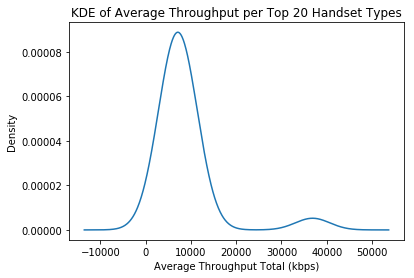

In [33]:
# Group by Handset Type
grouped_by_handset = customer_info.groupby('Most Common Handset Type')

# Sort by Group Size (Descending) and Select Top 20
top_20_handsets = (grouped_by_handset.size()
                   .sort_values(ascending=False)
                   .head(20)
                   .index.tolist())

# Filter Data for Top 20 Handsets
top_20_data = customer_info[customer_info['Most Common Handset Type'].isin(top_20_handsets)]

# Extract Average Throughput for Top 20
avg_throughput_per_handset = top_20_data.groupby('Most Common Handset Type')['Average Throughput Total'].mean()

avg_throughput_per_handset.plot(kind='kde')
plt.xlabel('Average Throughput Total (kbps)')
plt.ylabel('Density')
plt.title('KDE of Average Throughput per Top 20 Handset Types')
plt.show()


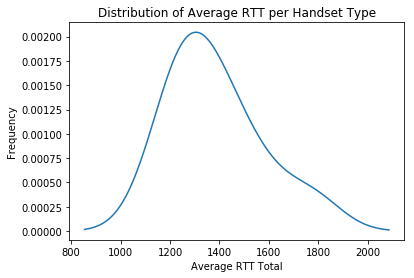

In [34]:
# Assuming avg_throughput_per_handset is the Series containing average throughput

avg_rtt_per_handset.sort_values(ascending=False).head(10).plot(kind='kde')
plt.xlabel('Average RTT Total')
plt.ylabel('Frequency')
plt.title('Distribution of Average RTT per Handset Type')
plt.show()

In [35]:
customer_info.columns

Index(['MSISDN/Number', 'Average TCP Retransmission (DL)',
       'Average TCP Retransmission (UL)', 'Average RTT (DL)',
       'Average RTT (UL)', 'Most Common Handset Type',
       'Average Throughput (DL)', 'Average Throughput (UL)',
       'Average TCP Retransmission Total', 'Average RTT Total',
       'Average Throughput Total'],
      dtype='object')

In [36]:
# Select the user experience metrics
user_experience_metrics = ['Average TCP Retransmission Total',
                           'Average RTT Total', 'Average Throughput Total']

# Create a DataFrame containing only the user experience metrics
user_experience_df = customer_info[user_experience_metrics]

# Scale features 
scaler = StandardScaler()
scaled_user_experience_np = scaler.fit_transform(user_experience_df)

In [37]:
scaled_user_experience_np[:10]

array([[ 0.36353397, -0.41938822, -0.61251243],
       [ 0.36353397, -0.5329819 , -0.61121611],
       [ 0.36353397,  0.19749054, -0.61132883],
       [-0.98359199, -0.13161755, -0.60281822],
       [-0.03132788, -0.3171539 ,  0.57258848],
       [-0.30997418, -0.19425088, -0.39394184],
       [-0.33108485, -0.56706001,  0.5812561 ],
       [-0.983643  , -0.37395074, -0.5465129 ],
       [ 0.36353397,  0.19749054, -0.61146974],
       [ 0.31443886, -0.29822162, -0.60856711]])

In [38]:
# Reverse the weight of the feature metrics that has negative relation to user experience
scaled_user_experience_np[:, 0] = scaled_user_experience_np[:, 0] * -1
scaled_user_experience_np[:, 1] = scaled_user_experience_np[:, 1] * -1
scaled_user_experience_np[:10]

array([[-0.36353397,  0.41938822, -0.61251243],
       [-0.36353397,  0.5329819 , -0.61121611],
       [-0.36353397, -0.19749054, -0.61132883],
       [ 0.98359199,  0.13161755, -0.60281822],
       [ 0.03132788,  0.3171539 ,  0.57258848],
       [ 0.30997418,  0.19425088, -0.39394184],
       [ 0.33108485,  0.56706001,  0.5812561 ],
       [ 0.983643  ,  0.37395074, -0.5465129 ],
       [-0.36353397, -0.19749054, -0.61146974],
       [-0.31443886,  0.29822162, -0.60856711]])

In [39]:
scaled_user_experience_np[:10]

array([[-0.36353397,  0.41938822, -0.61251243],
       [-0.36353397,  0.5329819 , -0.61121611],
       [-0.36353397, -0.19749054, -0.61132883],
       [ 0.98359199,  0.13161755, -0.60281822],
       [ 0.03132788,  0.3171539 ,  0.57258848],
       [ 0.30997418,  0.19425088, -0.39394184],
       [ 0.33108485,  0.56706001,  0.5812561 ],
       [ 0.983643  ,  0.37395074, -0.5465129 ],
       [-0.36353397, -0.19749054, -0.61146974],
       [-0.31443886,  0.29822162, -0.60856711]])

In [40]:
# Convert scaled numpy array back to DataFrame
scaled_user_experience_df = pd.DataFrame(scaled_user_experience_np, columns=user_experience_df.columns)
scaled_user_experience_df.head()

,Average TCP Retransmission Total,Average RTT Total,Average Throughput Total
0,-0.363534,0.419388,-0.612512
1,-0.363534,0.532982,-0.611216
2,-0.363534,-0.197491,-0.611329
3,0.983592,0.131618,-0.602818
4,0.031328,0.317154,0.572588


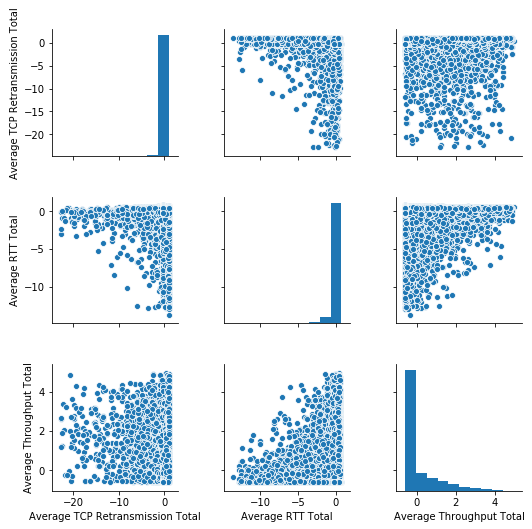

In [41]:
# The general scatter distribution for each of experience metrics
sns.pairplot(scaled_user_experience_df)
plt.show()

In [42]:
# Define the number of clusters (k=3)
k = 3

# Perform K-means clustering
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(scaled_user_experience_np)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

In [43]:
# Add cluster labels to the original DataFrame
customer_info['Cluster'] = kmeans.labels_

# View the first few rows of the DataFrame with cluster labels
print(customer_info['Cluster'].head())

0    0
1    0
2    0
3    0
4    0
Name: Cluster, dtype: int32


In [44]:
cluster_centers = kmeans.cluster_centers_
cluster_centers

array([[-0.20448809,  0.13720327, -0.47245699],
       [ 0.51541026, -5.64030819, -0.16352662],
       [ 0.59727582,  0.03194455,  1.49065294]])

In [45]:
customer_info['Cluster'].value_counts()

0    79420
2    25360
1     2075
Name: Cluster, dtype: int64

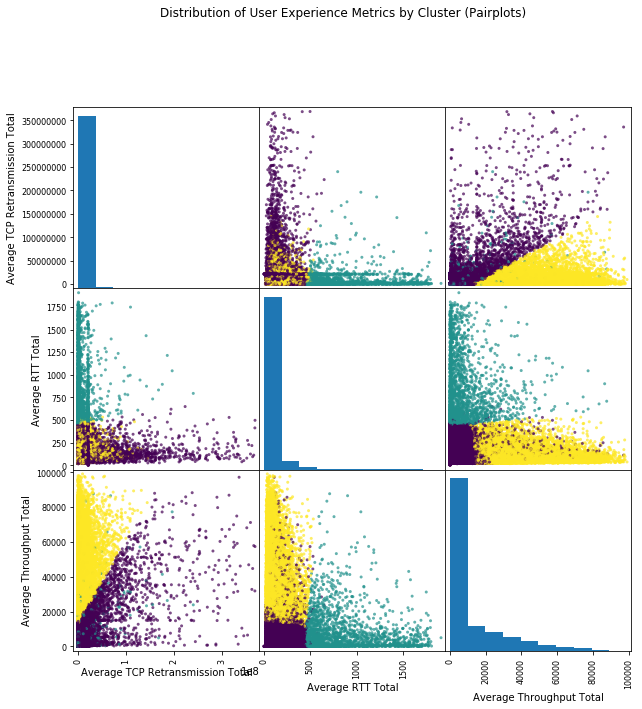

In [46]:
# Create a scatter matrix with cluster coloring
pd.plotting.scatter_matrix(customer_info[['Average TCP Retransmission Total', 'Average RTT Total', 'Average Throughput Total']], c=customer_info['Cluster'], cmap='viridis', figsize=(10, 10), alpha=0.7)
plt.suptitle('Distribution of User Experience Metrics by Cluster (Pairplots)', y=1.02)
plt.show()

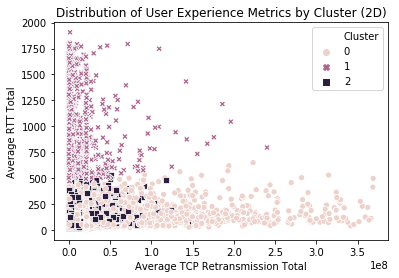

In [47]:
# Scatter plot the clusters using two features
x_feature="Average TCP Retransmission Total"
y_feature="Average RTT Total"
cluster_plot_2d(customer_info, x_feature, y_feature)

In [48]:
feature = ['Average TCP Retransmission Total', 'Average RTT Total', 'Average Throughput Total']

# Analyzing each clusters with essential dispersion properties based on the experience metrics
cluster_dispersion_analysis = analyze_cluster_dispersion(customer_info, feature=feature)

In [49]:
metric_cols = get_cluster_dispersion_columns(cluster_dispersion_analysis)

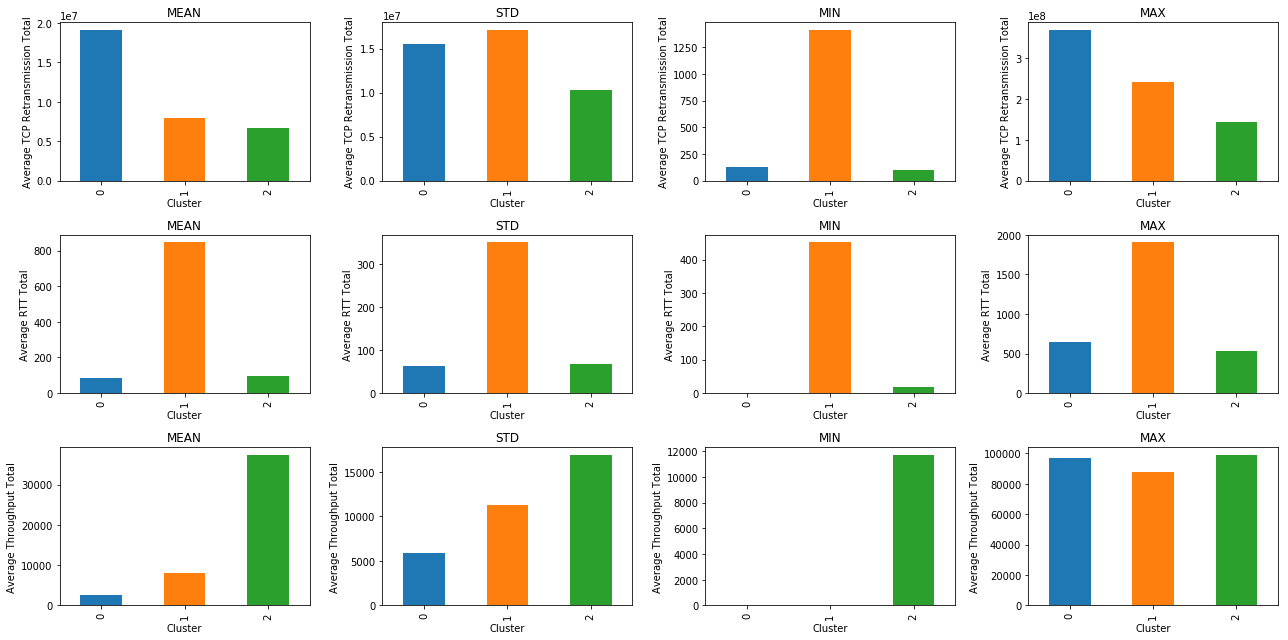

In [50]:
plot_cluster_dispersion_subplots(cluster_dispersion_analysis, metric_cols)

In [51]:
def find_min_value_cluster(cluster_centers):
    """
    Finds the cluster index with the minimum sum of values across all metrics.

    Args:
        cluster_centers (np.ndarray): An array of cluster centers (each row represents a cluster).

    Returns:
        int: The index of the cluster with the minimum sum of values.
    """
    # Calculate the mean and standard deviation for each metric
    mean_values = np.mean(cluster_centers, axis=0)
    std_values = np.std(cluster_centers, axis=0)

    # Normalize the cluster centers using z-score
    normalized_centers = (cluster_centers - mean_values) / std_values

    # Calculate the sum of normalized values for each cluster center
    sum_normalized_values = np.sum(normalized_centers, axis=1)

    # Identify the cluster with the minimum sum of normalized values
    min_sum_normalized_cluster = np.argmin(sum_normalized_values) 

    return min_sum_normalized_cluster

In [52]:
# Finding the minimum cluster in the experience metric values
min_cluster_index = find_min_value_cluster(cluster_centers)
print(f'Cluster index with the least average user experience is: {min_cluster_index}')

Cluster index with the least average user experience is: 0


In [53]:
features = user_experience_metrics
features

['Average TCP Retransmission Total',
 'Average RTT Total',
 'Average Throughput Total']

In [54]:
# Changing the cluster centers from numpy array into dataframe
cluster_centers = pd.DataFrame(cluster_centers, columns=features)
cluster_centers # cluster_centers.values to access the numpy array

,Average TCP Retransmission Total,Average RTT Total,Average Throughput Total
0,-0.204488,0.137203,-0.472457
1,0.515410,-5.640308,-0.163527
2,0.597276,0.031945,1.490653


In [55]:
# The cluster value for the minim cluster in the experience metrics
min_cluster_value = cluster_centers.values[min_cluster_index]
min_cluster_value

array([-0.20448809,  0.13720327, -0.47245699])

In [56]:
from sklearn.metrics import euclidean_distances
def calculate_euclidean_distance_score(df, min_cluster):
    """
    Calculates the Euclidean distance score for each row in the DataFrame
    by comparing the three features with the min_cluster.

    Args:
        df (pd.DataFrame): DataFrame with three features (Dur. (ms), Session Frequency, Total Traffic).
        min_cluster (pd.Series): Series representing the features of the min_cluster.

    Returns:
        pd.Series: A Series containing the Euclidean distance scores for each row.
    """
    try:
        # Ensure that the DataFrame and min_cluster have the same columns
        assert set(df.columns) == set(min_cluster.index), "Columns in DataFrame and min_cluster must match."
    except AssertionError as e:
        print(f'AssertionError: {e}')
        return
    
    # Calculate Euclidean distances
    score = euclidean_distances(df, [min_cluster])

    return score

In [57]:
score = euclidean_distances(scaled_user_experience_df, [min_cluster_value])
customer_info['Experience Score'] = score

In [58]:
features = ['Average TCP Retransmission Total',
 'Average RTT Total',
 'Average Throughput Total']
features + ['Experience Score','Cluster']

['Average TCP Retransmission Total',
 'Average RTT Total',
 'Average Throughput Total',
 'Experience Score',
 'Cluster']

In [59]:
customer_info['Cluster'].value_counts()

0    79420
2    25360
1     2075
Name: Cluster, dtype: int64

In [60]:
# Top 10 users with highest experience based on the metrics by the telecom 
customer_info.sort_values(ascending=False, by='Experience Score')[['MSISDN/Number', 'Experience Score','Cluster'] + features].head(10)

,MSISDN/Number,Experience Score,Cluster,Average TCP Retransmission Total,Average RTT Total,Average Throughput Total
47144,3.366212e+10,23.059782,0,3.687675e+08,497.000000,57387.0
58387,3.366501e+10,22.812645,0,3.684462e+08,413.000000,31901.0
59734,3.366537e+10,22.681834,0,3.661276e+08,112.000000,57928.0
96372,3.376180e+10,22.442535,0,3.638227e+08,95.000000,44777.0
23388,3.365011e+10,22.361476,0,3.592816e+08,124.662883,71217.0
22440,3.364886e+10,22.300231,0,3.622126e+08,218.000000,32787.0
31320,3.365849e+10,21.956197,0,3.556349e+08,228.000000,46923.0
68197,3.366815e+10,21.841495,0,3.516247e+08,79.000000,68167.0
59038,3.366519e+10,21.678514,0,3.532075e+08,275.000000,6541.0
39512,3.366031e+10,21.173070,0,3.356026e+08,112.000000,97204.0


In [61]:
if engine:
    print('Database Engine is on!')

Database Engine is on!


In [62]:
experience_table_name = 'experience_table'

Table 'experience_table' already exists.


False

In [202]:
exported_features = ['MSISDN/Number', 'Most Common Handset Type', 'Average TCP Retransmission Total', 'Average RTT Total', 'Average Throughput Total', 'Cluster', 'Experience Score']
exported_customer_info = customer_info[exported_features]
# Rename columns for clarity
exported_customer_info.rename(columns={'MSISDN/Number': 'Number',
                              'Most Common Handset Type': 'Handset',
                              'Average TCP Retransmission Total': 'TCP Retransmission',
                              'Average RTT Total': 'RTT',
                              'Average Throughput Total': 'Throughput'}, inplace=True)

# Display aggregated information per customer
exported_customer_info.head()

,Number,Handset,TCP Retransmission,RTT,Throughput,Cluster,Experience Score
0,3.360100e+10,Huawei P20 Lite Huawei Nova 3E,2.156957e+07,46.000000,76.000000,0,0.352901
1,3.360100e+10,Apple iPhone 7 (A1778),2.156957e+07,31.000000,99.000000,0,0.448543
2,3.360100e+10,undefined,2.156957e+07,127.458589,97.000000,0,0.395728
3,3.360101e+10,Apple iPhone 5S (A1457),7.607247e+05,84.000000,248.000000,0,1.195224
4,3.360101e+10,Apple iPhone Se (A1723),1.547020e+07,59.500000,21102.714323,0,1.086329
